In [ ]:
from google.colab import drive

In [ ]:
import h5py
import numpy as np
import os
from PIL import Image
from PIL.Image import Image as Image_t
import matplotlib.pyplot as plt
import torch

from abc import ABC, abstractmethod
from typing import Type, Union


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode as IM
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np
from tqdm.notebook import tqdm

In [ ]:

class storage_class(ABC):
    def __init__(self, config: dict):
        self.config = config
        self.pos = 0
        self.__locked = False

    @property
    @abstractmethod
    def dataset_size(self) -> int:
        """
        Вернуть количество пар (изображение, маска) в датасете
        """
        pass

    @abstractmethod
    def append(self, input_chunk: np.array, target_chunk: np.array) -> None:
        """
        Добавить в датасет блок изображений `input_chunk` и блок масок `target_chunk`
        """
        pass

    @abstractmethod
    def lock(self) -> None:
        """
        Закрыть режим записи, открыть в режиме чтения
        """
        pass

    @abstractmethod
    def __getitem__(self, idx: int) -> tuple[Image_t, Image_t]:
        """
        Вернуть пару (изображение, маска) по индексу `idx`
        """
        pass


class storage_hdf5(storage_class):
    def __init__(self, config):
        super().__init__(config)

        self.dataset = h5py.File(f'{config["annotation_file"].rstrip(".txt")}.h5', 'a')
        self.dataset.create_dataset("input", shape=(config["dataset_size"], *config["target_shape"], 3), dtype=np.uint8)
        self.dataset.create_dataset("label",  shape=(config["dataset_size"]), dtype=np.uint8)

    @property
    def dataset_size(self):
        assert self.dataset["label"].shape[0] == self.config["dataset_size"]
        return self.config["dataset_size"]

    def append(self, input_chunk, label_chunk):
        l_idx = self.pos * self.config["chunk_size"]
        r_idx = min(self.config["dataset_size"], l_idx + self.config["chunk_size"])
        self.dataset["input"][l_idx:r_idx] = input_chunk[:r_idx-l_idx]
        self.dataset["label"][l_idx:r_idx] = label_chunk[:r_idx-l_idx]
        self.pos += 1

    def lock(self):
        self.dataset.close()
        self.dataset = h5py.File(f'{self.config["annotation_file"].rstrip(".txt")}.h5', 'r')
        self.__locked = True

    def __getitem__(self, idx):
        if not(self.__locked):
            raise AttributeError("HDF5 file is not locked. Access denied.")
        return Image.fromarray(self.dataset["input"][idx]), self.dataset["label"][idx]

**Загрузка Данных**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qq /content/drive/MyDrive/termwork/Data.zip

In [ ]:
def resize(img, target_shape):
    assert target_shape[0] == target_shape[1]


    img = transforms.Resize(target_shape[0])(img)
    resize_transform = transforms.Compose([
        transforms.CenterCrop(target_shape[0]),
        transforms.Lambda(lambda img: np.array(img))
    ])

    return resize_transform(img)

In [ ]:
def prepare_dataset(config, storage_class=storage_hdf5):
    """
    Предобрабатывает датасет и эффективно его сохраняет на диск
    """
    with open(config["annotation_file"]) as f:
        lines = f.readlines()

    input_chunk = np.empty((config["chunk_size"], *config["target_shape"], 3), dtype=np.uint8)
    label_chunk = np.empty((config["chunk_size"]), dtype=np.uint8)

    config["dataset_size"] = len(lines)
    num_chunks = config["dataset_size"] // config["chunk_size"] + bool(config["dataset_size"] % config["chunk_size"])
    dataset = storage_class(config)

    for chunk_idx in tqdm(range(num_chunks)):
        for pos in range(config["chunk_size"]):
            flat_idx = chunk_idx * config["chunk_size"] + pos
            if (flat_idx >= config["dataset_size"]):
                break

            img_name, label = lines[flat_idx].rstrip("\n").split(' ')

            input_raw = Image.open(os.path.join(config["input_dir"], img_name + ".jpg")).convert("RGB")

            input_chunk[pos] = resize(input_raw, config["target_shape"])
            label_chunk[pos] = label
        dataset.append(input_chunk, label_chunk)
    dataset.lock()

    return dataset

In [ ]:
!rm -rf Data/trainval.h5 Data/trainval

# Конфигурация датасета
default_config = {
             "input_dir": "Data/background_object",
             "target_shape": (512, 512),
             "chunk_size": 512,
            }

# Конфигурации обучающей и тестовой выборок отличаются файлов аннотации
config_train = {"annotation_file":  "Data/trainval.txt"} | default_config
config_test = {"annotation_file": "Data/test.txt"} | default_config

train_data_hdf5 = prepare_dataset(config_train, storage_hdf5)



  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
from torchvision.transforms.functional import hflip
class HorizontalFlip():
    def __init__(self, prob: float):
        self.p = prob

    def __call__(self, pair):
        if (np.random.binomial(1, self.p)):
            pair = (hflip(pair[0]), pair[1])
        return pair


In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

t_dict = {
    "forward_input": transforms.Compose([
        transforms.PILToTensor(),
        transforms.Lambda(lambda x: x.float().to(DEVICE)/255.0),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]),
    "backward_input": transforms.Compose([
        transforms.Normalize(mean=[0.0, 0.0, 0.0],
                                     std=[1./0.229, 1./0.224, 1./0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                                     std=[1.0, 1.0, 1.0]),
        transforms.Lambda(lambda x: x.permute(1, 2, 0).cpu().numpy())
    ]),
    "augment": transforms.Compose([
        HorizontalFlip(0.5)
    ]),
}

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, dataset_raw: Type[storage_class], transforms: dict, train_flag: bool = True):
        """
        Наследуем весь функционал из `Dataset` для наших данных `dataset_raw`
        `transforms` содержит преобразования PIL.Image <-> torch.tensor и аугментации
        `train_flag` регулирует аугментацию данных (для тестовой выборки она не нужна)
        """
        super().__init__()
        self.dataset_raw = dataset_raw
        self.transforms = transforms
        self.train_flag = train_flag

    def __len__(self):
        return self.dataset_raw.dataset_size

    def __getitem__(self, idx: int) -> tuple[Image_t, Image_t]:
        input, label = self.dataset_raw[idx]

        if (self.train_flag):
            input, label = self.transforms["augment"]((input, label))

        return self.transforms["forward_input"](input), label

In [ ]:
from torch.utils.data import random_split

def split_train_val(train_data, train_portion = 0.9):
    trainval_dataset = SegmentationDataset(train_data, t_dict, train_flag=True)

    train_size = int(len(trainval_dataset) * train_portion)
    val_size = len(trainval_dataset) - train_size
    return random_split(trainval_dataset, [train_size, val_size])

train_dataset, val_dataset = split_train_val(train_data_hdf5)

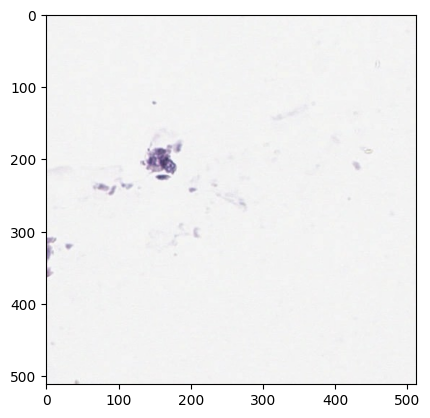

In [ ]:
plt.imshow(t_dict['backward_input'](train_dataset[0][0]))

In [ ]:
dataloader_config = {
    "batch_size": 16,
    "shuffle": True,
    "num_workers": 0
}
train_dataloader = DataLoader(train_dataset, **dataloader_config)
val_dataloader = DataLoader(val_dataset, **dataloader_config)

In [ ]:
dataloader_config = {
    "batch_size": 1,
    "shuffle": False,
    "num_workers": 0
}
test_data_hdf5 = prepare_dataset(config_test, storage_hdf5)
test_dataset_hdf5 = SegmentationDataset(test_data_hdf5, t_dict, train_flag=False)
test_dataloader = DataLoader(test_dataset_hdf5, **dataloader_config)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
import torch
#model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# or any of these variants
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=False)
model.fc = nn.Linear(512, 2)
model.to(DEVICE)
print(model)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def compute_metrics(
    outputs: torch.Tensor,
    labels: torch.LongTensor,
):
    """

    Args:
        outputs: the model outputs (batch_size, num_classes, sequence_len)
        labels: the correct classes (batch_size, sequence_len)

    Returns:
        metrics: mapping metric names to their corresponding values
    """

    metrics = {}
    y_true = None
    y_pred = None

    y_true = labels.to('cpu').detach().numpy().flatten()
    y_pred = outputs.to('cpu').detach().numpy().argmax(axis=1).flatten()

    metrics['accuracy'] = accuracy_score(
        y_true=y_true,
        y_pred=y_pred,
    )

    for metric_func in [precision_score, recall_score, f1_score]:
        metric_name = metric_func.__name__.split('_')[0]
        metrics[metric_name] = metric_func(
            y_true=y_true,
            y_pred=y_pred,
            average='macro',
            zero_division=0,
        )

    return metrics

In [ ]:
def train_epoch(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    writer: SummaryWriter,
    device: torch.device,
    epoch: int,
) -> None:


    model.train()

    epoch_loss = []
    batch_metrics_list = {
        'accuracy' : [],
        'precision' : [],
        'recall' : [],
        'f1' : []
    }


    for i, (input, labels) in tqdm(
        enumerate(dataloader),
        total=len(dataloader),
        desc="loop over train batches",
    ):
        input, labels = input.to(device), labels.to(device)

        outputs = None
        loss = None

        optimizer.zero_grad()
        outputs = model(input)
        #print(outputs.shape)
        #print(label.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        epoch_loss.append(loss.item())
        writer.add_scalar(
            tag="batch loss / train",
            scalar_value=loss.item(),
            global_step=epoch * len(dataloader) + i,
        )

        with torch.no_grad():
            model.eval()

            outputs_inference = model(input)

            model.train()

        #print(outputs_inference.argmax(axis=1))
        #print(labels)
        batch_metrics = compute_metrics(
            outputs=outputs_inference,
            labels=labels,
        )

        for metric_name, metric_value in batch_metrics.items():
            batch_metrics_list[metric_name].append(metric_value)
            writer.add_scalar(
                tag=f"batch {metric_name} / train",
                scalar_value=metric_value,
                global_step=epoch * len(dataloader) + i,
            )
        #batch_metrics_list.append(metric)

        #writer.add_scalar(
        #    tag=f"batch MAE / train",
        #    scalar_value=metric,
        #    global_step=epoch * len(dataloader) + i,
        #)

    avg_loss = np.mean(epoch_loss)
    print(f"Train loss: {avg_loss}\n")
    writer.add_scalar(
        tag="loss / train",
        scalar_value=avg_loss,
        global_step=epoch,
    )

    for metric_name, metric_value_list in batch_metrics_list.items():
        metric_value = np.mean(metric_value_list)
        print(f"Train {metric_name}: {metric_value}\n")
        writer.add_scalar(
            tag=f"{metric_name} / train",
            scalar_value=metric_value,
            global_step=epoch,
        )

    #metric_value = np.mean(batch_metrics_list)
    #print(f"Train MAE: {metric_value}\n")
    #writer.add_scalar(
    #    tag=f"MAE / train",
    #    scalar_value=metric_value,
    #    global_step=epoch,
    #)

In [ ]:
def evaluate_epoch(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    writer: SummaryWriter,
    device: torch.device,
    epoch: int,
) -> None:

    model.eval()

    epoch_loss = []
    batch_metrics_list = {
        'accuracy' : [],
        'precision' : [],
        'recall' : [],
        'f1' : []
    }

    with torch.no_grad():

        for i, (input, labels) in tqdm(
            enumerate(dataloader),
            total=len(dataloader),
            desc="loop over test batches",
        ):
            input, labels = input.to(device), labels.to(device)

            outputs = model(input)
            loss = criterion(outputs, labels)


            epoch_loss.append(loss.item())
            writer.add_scalar(
                tag="batch loss / test",
                scalar_value=loss.item(),
                global_step=epoch * len(dataloader) + i,
            )

            batch_metrics = compute_metrics(
                labels=labels,
                outputs=outputs,
            )

            for metric_name, metric_value in batch_metrics.items():

                batch_metrics_list[metric_name].append(metric_value)
                writer.add_scalar(
                    tag=f"batch {metric_name} / test",
                    scalar_value=metric_value,
                    global_step=epoch * len(dataloader) + i,
                )
            #batch_metrics_list.append(metric)
            #writer.add_scalar(
            #    tag=f"batch MAE / test",
            #    scalar_value=metric,
            #    global_step=epoch * len(dataloader) + i,
            #)

        avg_loss = np.mean(epoch_loss)
        print(f"Test loss:  {avg_loss}\n")
        writer.add_scalar(
            tag="loss / test",
            scalar_value=avg_loss,
            global_step=epoch,
        )


        for metric_name, metric_value_list in batch_metrics_list.items():
            metric_value = np.mean(metric_value_list)
            print(f"Test {metric_name}: {metric_value}\n")
            writer.add_scalar(
                tag=f"{metric_name} / test",
                scalar_value=np.mean(metric_value),
                global_step=epoch,
            )

        return np.mean(batch_metrics_list['f1'])
        #metric_value = np.mean(batch_metrics_list)
        #print(f"Test MAE: {metric_value}\n")
        #writer.add_scalar(
        #    tag=f"MAE / test",
        #    scalar_value=np.mean(metric_value),
        #    global_step=epoch,
        #)

In [ ]:
from torch.optim.lr_scheduler import StepLR

def train(
    n_epochs: int,
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    valid_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    writer: SummaryWriter,
    device: torch.device,
) -> None:

    scheduler = StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
    best_f1_score = 0
    for epoch in range(n_epochs):

        print(f"Epoch [{epoch+1} / {n_epochs}]\n")
        train_epoch(
            model=model,
            dataloader=train_dataloader,
            optimizer=optimizer,
            criterion=criterion,
            writer=writer,
            device=device,
            epoch=epoch,
        )

        cur_f1_score = evaluate_epoch(
            model=model,
            dataloader=valid_dataloader,
            criterion=criterion,
            writer=writer,
            device=device,
            epoch=epoch,
        )
        scheduler.step()
        if cur_f1_score > best_f1_score:
             best_f1_score = cur_f1_score
             torch.save(model.state_dict(), "best_model.pth")



In [ ]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir=f"logs")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,)
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([1., 10.], device='cuda'))

In [ ]:
train(
    n_epochs=20,
    model=model,
    train_dataloader=train_dataloader,
    valid_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    writer=writer,
    device=DEVICE,
)

Epoch [1 / 20]



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.17252826958347658

Train accuracy: 0.7027972027972028

Train precision: 0.5699620067189997

Train recall: 0.6827988930261658

Train f1: 0.5924736596186451



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.06164396763779223

Test accuracy: 0.9564732142857143

Test precision: 0.9627507041569542

Test recall: 0.950941332972583

Test f1: 0.9521568537241911

Epoch [2 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.09261745281380739

Train accuracy: 0.7519425019425019

Train precision: 0.6682639281852568

Train recall: 0.7436342309594058

Train f1: 0.6711922258451716



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.04277878685388714

Test accuracy: 0.9525669642857143

Test precision: 0.9589770472582972

Test recall: 0.9505433802308803

Test f1: 0.950006770512769

Epoch [3 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.061329257921999565

Train accuracy: 0.7613636363636364

Train precision: 0.6594976362021816

Train recall: 0.7466751682660774

Train f1: 0.6739433665763207



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.07269209122750908

Test accuracy: 0.9877232142857143

Test precision: 0.9887152777777778

Test recall: 0.9881572420634921

Test f1: 0.9876696832579186

Epoch [4 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.04969051608838584

Train accuracy: 0.8326048951048951

Train precision: 0.7478098533168462

Train recall: 0.8180439509984965

Train f1: 0.7681303834695796



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.15356094845628832

Test accuracy: 0.9525669642857143

Test precision: 0.9569523358585859

Test recall: 0.9492424242424242

Test f1: 0.9474704208401964

Epoch [5 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.048819858518956635

Train accuracy: 0.8587801087801088

Train precision: 0.7971428047476998

Train recall: 0.846995302677121

Train f1: 0.8068390516918258



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.2684184559620917

Test accuracy: 0.5401785714285714

Test precision: 0.2700892857142857

Test recall: 0.5

Test f1: 0.3462988862988863

Epoch [6 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.0541810643504263

Train accuracy: 0.8260975135975136

Train precision: 0.7407687543614118

Train recall: 0.8132124188942371

Train f1: 0.7594429074941836



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.5061575602740049

Test accuracy: 0.5390625

Test precision: 0.26953125

Test recall: 0.5

Test f1: 0.3472520072520072

Epoch [7 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.05403833061137556

Train accuracy: 0.9082167832167832

Train precision: 0.8814594108300402

Train recall: 0.8989658069203524

Train f1: 0.8784855867063704



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.03282878114259802

Test accuracy: 0.98046875

Test precision: 0.9759548611111111

Test recall: 0.9848090277777778

Test f1: 0.9782350357797929

Epoch [8 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.04114930577725954

Train accuracy: 0.9283216783216783

Train precision: 0.9121918582582919

Train recall: 0.922988122988123

Train f1: 0.908956511325803



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.08953078603371978

Test accuracy: 0.9564732142857143

Test precision: 0.9561620670995671

Test recall: 0.9581935425685426

Test f1: 0.9544321519553718

Epoch [9 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.04213154319204859

Train accuracy: 0.9083139083139083

Train precision: 0.8701929723345808

Train recall: 0.9022311895563643

Train f1: 0.8785565012452838



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.11151822039391845

Test accuracy: 0.7622767857142857

Test precision: 0.8099676365301365

Test recall: 0.7379024621212121

Test f1: 0.7105551859388387

Epoch [10 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.044755951204692127

Train accuracy: 0.9331293706293706

Train precision: 0.9156862174344691

Train recall: 0.9309480923117287

Train f1: 0.9166147845468915



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.04773281546658836

Test accuracy: 0.98046875

Test precision: 0.9810132575757576

Test recall: 0.9805420274170273

Test f1: 0.9794502710911379

Epoch [11 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.028252081598734834

Train accuracy: 0.986013986013986

Train precision: 0.9881777313595497

Train recall: 0.9838646202282565

Train f1: 0.984769701671618



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.04627712321234867

Test accuracy: 0.98828125

Test precision: 0.9878472222222222

Test recall: 0.9893465909090909

Test f1: 0.9878278584160938

Epoch [12 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.02737814602784005

Train accuracy: 0.9868881118881119

Train precision: 0.9869626585535677

Train recall: 0.9875578966488059

Train f1: 0.9864336741677667



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.057598892351961695

Test accuracy: 0.98828125

Test precision: 0.9898538961038961

Test recall: 0.9864583333333333

Test f1: 0.9872934083460398

Epoch [13 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.026961041033150744

Train accuracy: 0.9868881118881119

Train precision: 0.9868613709522801

Train recall: 0.9870915700461155

Train f1: 0.986063549409236



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.044973944561206736

Test accuracy: 0.9760044642857143

Test precision: 0.9774170274170275

Test recall: 0.9752468885281386

Test f1: 0.9746441123376108

Epoch [14 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.027528844144882412

Train accuracy: 0.9842657342657343

Train precision: 0.9846495676041132

Train recall: 0.9844945458581823

Train f1: 0.9833512688171289



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.04352185707830358

Test accuracy: 0.9799107142857143

Test precision: 0.9812127976190477

Test recall: 0.980654761904762

Test f1: 0.9797638125763126

Epoch [15 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.025989122941139173

Train accuracy: 0.9855769230769231

Train precision: 0.9864011474151335

Train recall: 0.9850816724068473

Train f1: 0.9845667528546851



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.031750333931995556

Test accuracy: 0.9799107142857143

Test precision: 0.9741556186868687

Test recall: 0.9817088293650793

Test f1: 0.9757413066236595

Epoch [16 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.02713843449784143

Train accuracy: 0.986013986013986

Train precision: 0.9867489833398926

Train recall: 0.9855838605838605

Train f1: 0.9850773197229675



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.04200511079397984

Test accuracy: 0.984375

Test precision: 0.9862689393939394

Test recall: 0.9815340909090909

Test f1: 0.9826839826839826

Epoch [17 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.024778356495593394

Train accuracy: 0.986451048951049

Train precision: 0.9855270603522351

Train recall: 0.9866234484241477

Train f1: 0.9849526522232711



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.03224638549727388

Test accuracy: 0.98046875

Test precision: 0.9833495497557998

Test recall: 0.9769965277777778

Test f1: 0.97769161308248

Epoch [18 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.026934639871091147

Train accuracy: 0.9873251748251748

Train precision: 0.9874917623169371

Train recall: 0.9876010353283081

Train f1: 0.9867019569228969



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.030123266435111873

Test accuracy: 0.984375

Test precision: 0.9859375

Test recall: 0.9848214285714285

Test f1: 0.9839663260715892

Epoch [19 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.022863857654880707

Train accuracy: 0.9868881118881119

Train precision: 0.9858888586161313

Train recall: 0.9871126348399075

Train f1: 0.9855915616390538



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.032840441264852416

Test accuracy: 0.98046875

Test precision: 0.981125992063492

Test recall: 0.9806547619047619

Test f1: 0.9801717718126387

Epoch [20 / 20]



loop over train batches:   0%|          | 0/143 [00:00<?, ?it/s]

Train loss: 0.021975399661928064

Train accuracy: 0.9873251748251748

Train precision: 0.9870722323519527

Train recall: 0.9871756254623387

Train f1: 0.9862169457413196



loop over test batches:   0%|          | 0/16 [00:00<?, ?it/s]

Test loss:  0.032805479953822214

Test accuracy: 0.98046875

Test precision: 0.9825126262626263

Test recall: 0.9783718885281385

Test f1: 0.9790428353895846



In [ ]:
model.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

In [ ]:
evaluate_epoch(
    model=model,
    dataloader=test_dataloader,
    criterion=criterion,
    writer=writer,
    device=DEVICE,
    epoch=1,
)

loop over test batches:   0%|          | 0/988 [00:00<?, ?it/s]

Test loss:  0.1085909036687069

Test accuracy: 0.9605263157894737

Test precision: 0.9605263157894737

Test recall: 0.9605263157894737

Test f1: 0.9605263157894737



0.9605263157894737

In [ ]:
def process_batches(dataloader):
    model.eval()

    true = []
    pred = []
    with torch.no_grad():
        for i, (inputs, labels) in tqdm(
                enumerate(dataloader),
                total=len(dataloader),
            ):
            outputs = model(inputs).argmax(1).cpu().numpy()
            true.extend(labels.numpy())
            pred.extend(outputs)
    return  true, pred

In [ ]:
def errors(trues, preds, dataset):
    trues = trues
    preds = preds
    idxs = np.where(np.not_equal(trues, preds))[0]
    fig, axs = plt.subplots(len(idxs))
    fig.set_figheight(100)
    fig.set_figwidth(100)
    for i, idx in enumerate(idxs):
        axs[i].imshow(t_dict['backward_input'](dataset[idx][0]))
        axs[i].set_title(f"predicted CLASS: {preds[idx]}, true CLASS: {trues[idx]}")
    fig.tight_layout()
    #plt.show()

  0%|          | 0/988 [00:00<?, ?it/s]

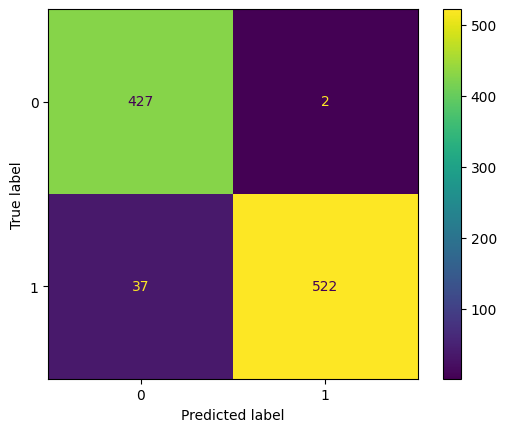

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def print_confusion_matrix(true, pred):
    disp = ConfusionMatrixDisplay(confusion_matrix(true, pred))
    disp.plot()
    plt.show()
trues, preds = process_batches(test_dataloader)
print_confusion_matrix(trues, preds)

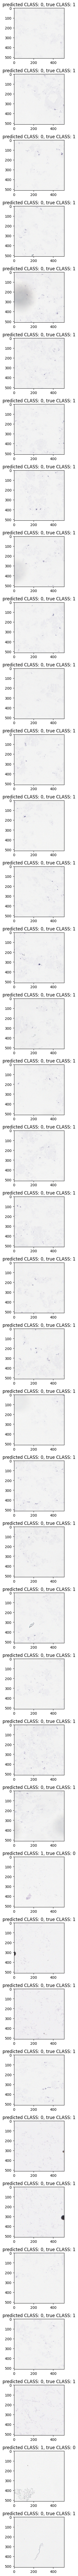

In [ ]:
errors(trues, preds, test_dataloader.dataset)